# Face Generation

### Get the Data

Using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

We've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper
%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

In [ ]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [ ]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    transform_fn = transforms.Compose([transforms.Resize(image_size),  
                                         transforms.ToTensor()])                             

    num_workers = 0
    img_path = data_dir
    img_dataset = datasets.ImageFolder(img_path, transform_fn)
    data_loader = torch.utils.data.DataLoader(dataset=img_dataset, 
                             batch_size=batch_size,
                             shuffle=True, 
                             num_workers=num_workers)
    return data_loader

## Create a DataLoader

In [ ]:
# Define function hyperparameters
batch_size = 128 # Define the batch size between 32-256
img_size   = 32  # small to fast training process in initial model

celeba_train_loader = get_dataloader(batch_size, img_size)

In [ ]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

---
# Define the Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## Initialize the weights of your networks

In [ ]:
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__
    init_gain=0.02
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or 
                                 classname.find('Linear') != -1 or 
                                 classname.find('BatchNorm2d')):
        init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)


In [ ]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

# Model
I will use CycleGAN idea to generate face from random noise image as input to the generator


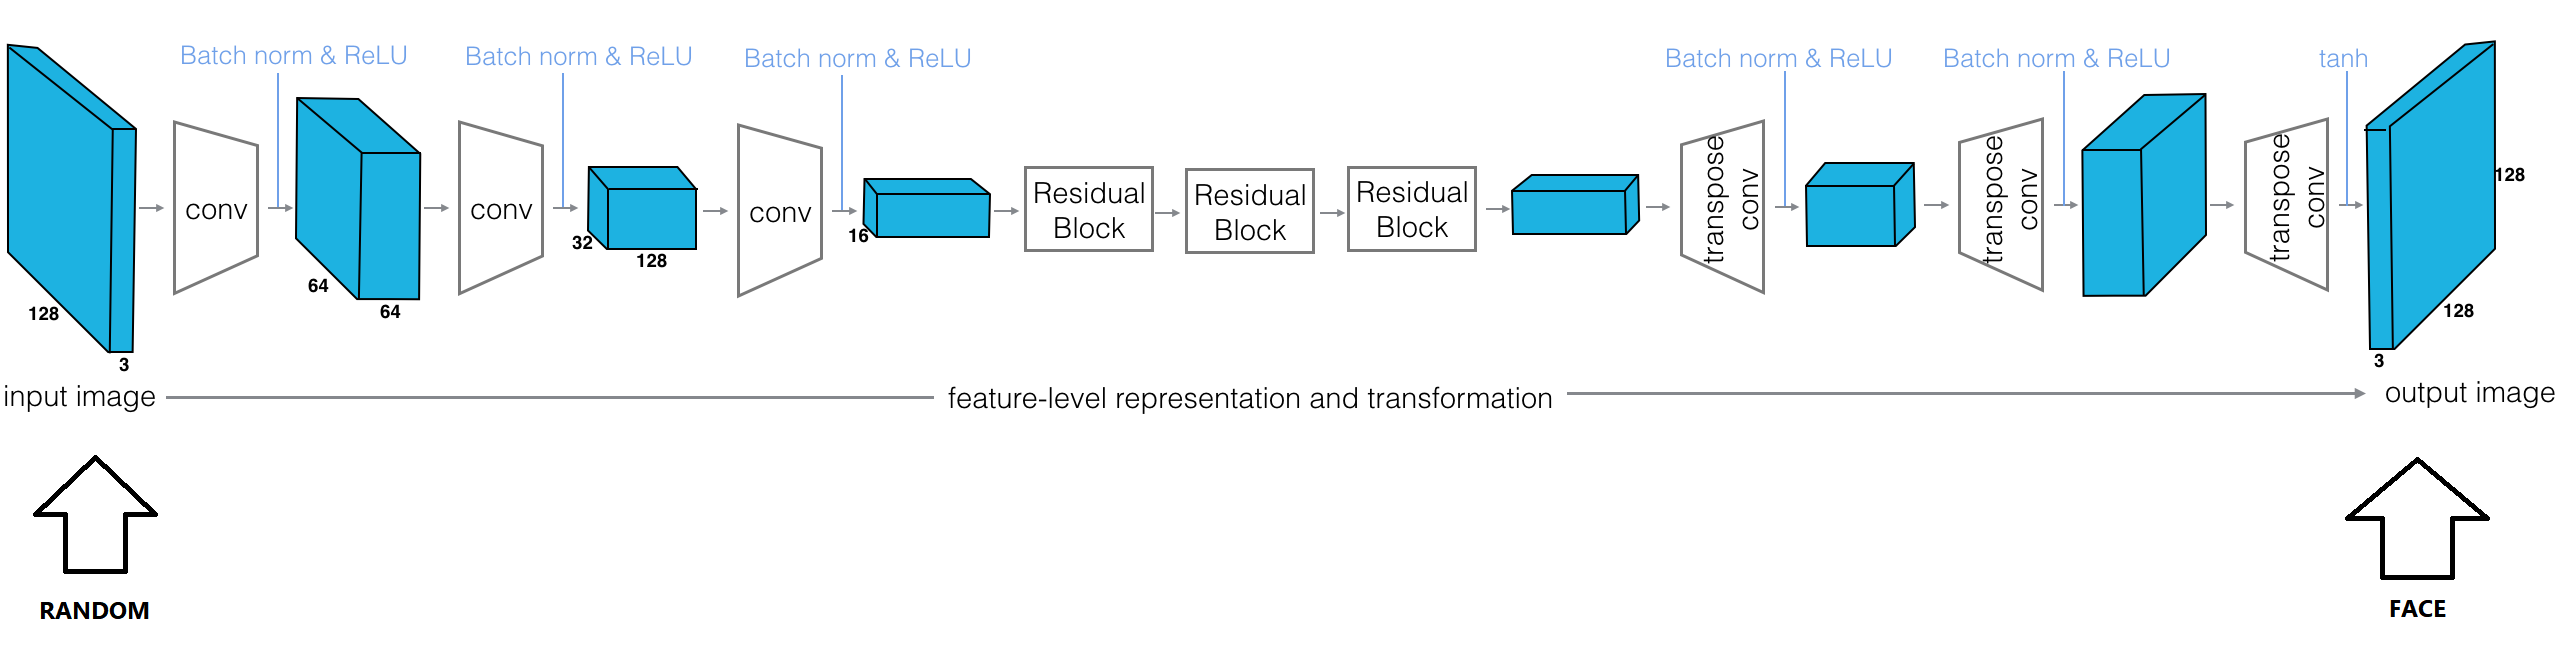

## Define the model

In [ ]:
# residual block class
class ResidualBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()

        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # last, classification layer
        x = self.conv5(x)
        return x


class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out        

## Create the complete network


In [ ]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

 
    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [ ]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

### Define Loss Functions

In [ ]:
def real_loss(D_out):
    loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    loss = torch.mean((D_out)**2)
    return loss

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return lambda_weight*reconstr_loss

### Define the Optimizers

In [ ]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

## Training a CycleGAN

### Generate a fake images 

In [ ]:
# get fake random image
def get_fake_image():
    # Generate fake images
    z = np.random.uniform(0, 1, size=(batch_size, 3,32,32))
    z = torch.from_numpy(z).float()
    return z

In [ ]:
z = get_fake_image()
print(z.shape)
print(z[0].shape)
imshow(z[0])

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(z[idx])

In [ ]:
# import save code
from helpers import save_samples, checkpoint

# train the network
def training_loop(n_epochs=1000):
    
    print_every=2
    losses = []
    fixed_Y = get_fake_image()[0]
    fixed_Y = scale(fixed_Y)

    
    for epoch in range(1, n_epochs+1):
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)

            images_X = real_images
            images_X = scale(images_X) # make sure to scale to a range -1 to 1

            images_Y = get_fake_image()
            images_Y = scale(images_Y)

            # move images to GPU if available (otherwise stay on CPU)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            images_X = images_X.to(device)
            images_Y = images_Y.to(device)

            # ============================================
            #            TRAIN THE DISCRIMINATORS
            # ============================================

            ##   1: D_X, real and fake loss components   ##
            d_x_optimizer.zero_grad()

            out_x = D_X(images_X)
            D_X_real_loss = real_loss(out_x)

            fake_X = G_YtoX(images_Y)

            out_x = D_X(fake_X)
            D_X_fake_loss = fake_loss(out_x)

            d_x_loss = D_X_real_loss + D_X_fake_loss
            d_x_loss.backward()
            d_x_optimizer.step()

            ##   2: D_Y, real and fake loss components   ##
            d_y_optimizer.zero_grad()


            out_y = D_Y(images_Y)
            D_Y_real_loss = real_loss(out_y)

            fake_Y = G_XtoY(images_X)

            out_y = D_Y(fake_Y)
            D_Y_fake_loss = fake_loss(out_y)

            d_y_loss = D_Y_real_loss + D_Y_fake_loss
            d_y_loss.backward()
            d_y_optimizer.step()

            # =========================================
            #            TRAIN THE GENERATORS
            # =========================================

            ##    1: generate fake X images and reconstructed Y images    ##
            g_optimizer.zero_grad()

            fake_X = G_YtoX(images_Y)

            out_x = D_X(fake_X)
            g_YtoX_loss = real_loss(out_x)

            reconstructed_Y = G_XtoY(fake_X)
            reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


            ##    2: generate fake Y images and reconstructed X images    ##
            
            fake_Y = G_XtoY(images_X)
            out_y = D_Y(fake_Y)
            g_XtoY_loss = real_loss(out_y)

            reconstructed_X = G_YtoX(fake_Y)
            reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

            g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
            g_total_loss.backward()
            g_optimizer.step()


            # Print the log info
            if epoch % print_every == 0:
                # append real and fake discriminator losses and the generator loss
                losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                        epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            
        sample_every=10
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()


        checkpoint_every=1000
         # Save the model parameters
        if epoch % checkpoint_every == 0:
             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [74]:
n_epochs = 10 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(n_epochs=n_epochs)

Epoch [    2/   10] | d_X_loss: 0.3875 | d_Y_loss: 0.0272 | g_total_loss: 8.3439
Epoch [    2/   10] | d_X_loss: 0.3962 | d_Y_loss: 0.2814 | g_total_loss: 9.2769
Epoch [    2/   10] | d_X_loss: 0.3981 | d_Y_loss: 0.1944 | g_total_loss: 8.1685
Epoch [    2/   10] | d_X_loss: 0.3908 | d_Y_loss: 0.2770 | g_total_loss: 8.8796
Epoch [    2/   10] | d_X_loss: 0.3444 | d_Y_loss: 0.1990 | g_total_loss: 7.9660
Epoch [    2/   10] | d_X_loss: 0.3474 | d_Y_loss: 0.5133 | g_total_loss: 9.2047
Epoch [    2/   10] | d_X_loss: 0.4309 | d_Y_loss: 0.2249 | g_total_loss: 8.6455
Epoch [    2/   10] | d_X_loss: 0.4550 | d_Y_loss: 0.0852 | g_total_loss: 7.9948
Epoch [    2/   10] | d_X_loss: 0.4514 | d_Y_loss: 0.2821 | g_total_loss: 9.1360
Epoch [    2/   10] | d_X_loss: 0.3544 | d_Y_loss: 0.1589 | g_total_loss: 8.3966
Epoch [    2/   10] | d_X_loss: 0.4197 | d_Y_loss: 0.3321 | g_total_loss: 8.5525
Epoch [    2/   10] | d_X_loss: 0.4482 | d_Y_loss: 0.1744 | g_total_loss: 8.4771
Epoch [    2/   10] | d_X_lo

Epoch [    2/   10] | d_X_loss: 0.4788 | d_Y_loss: 0.1604 | g_total_loss: 8.1776
Epoch [    2/   10] | d_X_loss: 0.4483 | d_Y_loss: 0.1779 | g_total_loss: 8.8845
Epoch [    2/   10] | d_X_loss: 0.4359 | d_Y_loss: 0.1433 | g_total_loss: 8.4259
Epoch [    2/   10] | d_X_loss: 0.4120 | d_Y_loss: 0.0863 | g_total_loss: 8.1469
Epoch [    2/   10] | d_X_loss: 0.3354 | d_Y_loss: 0.1673 | g_total_loss: 8.7289
Epoch [    2/   10] | d_X_loss: 0.4145 | d_Y_loss: 0.0646 | g_total_loss: 8.0084
Epoch [    2/   10] | d_X_loss: 0.4017 | d_Y_loss: 0.1572 | g_total_loss: 8.5206
Epoch [    2/   10] | d_X_loss: 0.3977 | d_Y_loss: 0.1843 | g_total_loss: 8.7871
Epoch [    2/   10] | d_X_loss: 0.4360 | d_Y_loss: 0.1793 | g_total_loss: 8.0949
Epoch [    2/   10] | d_X_loss: 0.3454 | d_Y_loss: 0.1824 | g_total_loss: 8.9216
Epoch [    2/   10] | d_X_loss: 0.3872 | d_Y_loss: 0.1030 | g_total_loss: 8.5088
Epoch [    2/   10] | d_X_loss: 0.3865 | d_Y_loss: 0.2554 | g_total_loss: 9.0020
Epoch [    2/   10] | d_X_lo

Epoch [    2/   10] | d_X_loss: 0.4014 | d_Y_loss: 0.1600 | g_total_loss: 8.4823
Epoch [    2/   10] | d_X_loss: 0.3820 | d_Y_loss: 0.3878 | g_total_loss: 9.8040
Epoch [    2/   10] | d_X_loss: 0.3432 | d_Y_loss: 0.5001 | g_total_loss: 8.1833
Epoch [    2/   10] | d_X_loss: 0.3660 | d_Y_loss: 0.1023 | g_total_loss: 7.8478
Epoch [    2/   10] | d_X_loss: 0.3242 | d_Y_loss: 0.4822 | g_total_loss: 8.8344
Epoch [    2/   10] | d_X_loss: 0.3865 | d_Y_loss: 0.2017 | g_total_loss: 8.6906
Epoch [    2/   10] | d_X_loss: 0.3787 | d_Y_loss: 0.2357 | g_total_loss: 8.2503
Epoch [    2/   10] | d_X_loss: 0.4217 | d_Y_loss: 0.3799 | g_total_loss: 8.1250
Epoch [    2/   10] | d_X_loss: 0.3770 | d_Y_loss: 0.1365 | g_total_loss: 8.8891
Epoch [    2/   10] | d_X_loss: 0.3702 | d_Y_loss: 0.0844 | g_total_loss: 8.1515
Epoch [    2/   10] | d_X_loss: 0.4166 | d_Y_loss: 0.1583 | g_total_loss: 8.8747
Epoch [    2/   10] | d_X_loss: 0.4584 | d_Y_loss: 0.1719 | g_total_loss: 8.2290
Epoch [    2/   10] | d_X_lo

Epoch [    2/   10] | d_X_loss: 0.3958 | d_Y_loss: 0.1391 | g_total_loss: 7.9597
Epoch [    2/   10] | d_X_loss: 0.3955 | d_Y_loss: 0.0673 | g_total_loss: 8.0027
Epoch [    2/   10] | d_X_loss: 0.3634 | d_Y_loss: 0.4306 | g_total_loss: 9.1484
Epoch [    2/   10] | d_X_loss: 0.2992 | d_Y_loss: 0.3007 | g_total_loss: 7.8941
Epoch [    2/   10] | d_X_loss: 0.3550 | d_Y_loss: 0.1055 | g_total_loss: 8.4384
Epoch [    2/   10] | d_X_loss: 0.3720 | d_Y_loss: 0.1598 | g_total_loss: 8.2908
Epoch [    2/   10] | d_X_loss: 0.4123 | d_Y_loss: 0.1700 | g_total_loss: 8.9316
Epoch [    2/   10] | d_X_loss: 0.4489 | d_Y_loss: 0.1474 | g_total_loss: 7.7602
Epoch [    2/   10] | d_X_loss: 0.4162 | d_Y_loss: 0.3021 | g_total_loss: 9.0129
Epoch [    2/   10] | d_X_loss: 0.3366 | d_Y_loss: 0.1983 | g_total_loss: 8.0037
Epoch [    2/   10] | d_X_loss: 0.3478 | d_Y_loss: 0.0727 | g_total_loss: 8.5367
Epoch [    2/   10] | d_X_loss: 0.3217 | d_Y_loss: 0.4102 | g_total_loss: 8.9254
Epoch [    2/   10] | d_X_lo

Epoch [    2/   10] | d_X_loss: 0.3093 | d_Y_loss: 0.0934 | g_total_loss: 9.1832
Epoch [    2/   10] | d_X_loss: 0.3702 | d_Y_loss: 0.1713 | g_total_loss: 8.8179
Epoch [    2/   10] | d_X_loss: 0.4661 | d_Y_loss: 0.2235 | g_total_loss: 8.5083
Epoch [    2/   10] | d_X_loss: 0.4431 | d_Y_loss: 0.3161 | g_total_loss: 8.8169
Epoch [    2/   10] | d_X_loss: 0.4178 | d_Y_loss: 0.1937 | g_total_loss: 7.9486
Epoch [    2/   10] | d_X_loss: 0.3416 | d_Y_loss: 0.5182 | g_total_loss: 9.2325
Epoch [    2/   10] | d_X_loss: 0.3615 | d_Y_loss: 0.2128 | g_total_loss: 7.7061
Epoch [    2/   10] | d_X_loss: 0.4365 | d_Y_loss: 0.3290 | g_total_loss: 9.1016
Epoch [    2/   10] | d_X_loss: 0.4000 | d_Y_loss: 0.2217 | g_total_loss: 8.2322
Epoch [    2/   10] | d_X_loss: 0.4029 | d_Y_loss: 0.1279 | g_total_loss: 7.9510
Epoch [    2/   10] | d_X_loss: 0.4069 | d_Y_loss: 0.3814 | g_total_loss: 8.8072
Epoch [    2/   10] | d_X_loss: 0.3745 | d_Y_loss: 0.1907 | g_total_loss: 8.7668
Epoch [    2/   10] | d_X_lo

Epoch [    2/   10] | d_X_loss: 0.7050 | d_Y_loss: 0.1714 | g_total_loss: 7.9378
Epoch [    2/   10] | d_X_loss: 0.3826 | d_Y_loss: 0.0521 | g_total_loss: 7.6611
Epoch [    2/   10] | d_X_loss: 0.3804 | d_Y_loss: 0.2542 | g_total_loss: 8.4190
Epoch [    2/   10] | d_X_loss: 0.3227 | d_Y_loss: 0.1315 | g_total_loss: 8.6598
Epoch [    2/   10] | d_X_loss: 0.3573 | d_Y_loss: 0.1846 | g_total_loss: 7.8380
Epoch [    2/   10] | d_X_loss: 0.4514 | d_Y_loss: 0.1805 | g_total_loss: 8.4749
Epoch [    2/   10] | d_X_loss: 0.3900 | d_Y_loss: 0.0980 | g_total_loss: 8.0253
Epoch [    2/   10] | d_X_loss: 0.4086 | d_Y_loss: 0.3537 | g_total_loss: 8.4496
Epoch [    2/   10] | d_X_loss: 0.4573 | d_Y_loss: 0.0864 | g_total_loss: 8.4439
Epoch [    2/   10] | d_X_loss: 0.3885 | d_Y_loss: 0.1798 | g_total_loss: 8.2342
Epoch [    2/   10] | d_X_loss: 0.3690 | d_Y_loss: 0.0858 | g_total_loss: 7.8554
Epoch [    2/   10] | d_X_loss: 0.2813 | d_Y_loss: 0.5115 | g_total_loss: 9.2466
Epoch [    2/   10] | d_X_lo

Epoch [    2/   10] | d_X_loss: 0.4143 | d_Y_loss: 0.1952 | g_total_loss: 8.1039
Epoch [    2/   10] | d_X_loss: 0.4257 | d_Y_loss: 0.1655 | g_total_loss: 8.4454
Epoch [    2/   10] | d_X_loss: 0.3863 | d_Y_loss: 0.1008 | g_total_loss: 8.3191
Epoch [    2/   10] | d_X_loss: 0.3946 | d_Y_loss: 0.0365 | g_total_loss: 8.0482
Epoch [    2/   10] | d_X_loss: 0.3913 | d_Y_loss: 0.4563 | g_total_loss: 9.2941
Epoch [    2/   10] | d_X_loss: 0.3664 | d_Y_loss: 0.4302 | g_total_loss: 7.8153
Epoch [    2/   10] | d_X_loss: 0.3731 | d_Y_loss: 0.3894 | g_total_loss: 8.0052
Epoch [    2/   10] | d_X_loss: 0.3286 | d_Y_loss: 0.1279 | g_total_loss: 8.8040
Epoch [    2/   10] | d_X_loss: 0.3247 | d_Y_loss: 0.1866 | g_total_loss: 8.0984
Epoch [    2/   10] | d_X_loss: 0.4037 | d_Y_loss: 0.2937 | g_total_loss: 8.3336
Epoch [    2/   10] | d_X_loss: 0.4323 | d_Y_loss: 0.1220 | g_total_loss: 8.8733
Epoch [    2/   10] | d_X_loss: 0.3888 | d_Y_loss: 0.1228 | g_total_loss: 7.9658
Epoch [    2/   10] | d_X_lo

Epoch [    4/   10] | d_X_loss: 0.3531 | d_Y_loss: 0.2727 | g_total_loss: 8.7733
Epoch [    4/   10] | d_X_loss: 0.3359 | d_Y_loss: 0.1634 | g_total_loss: 8.6286
Epoch [    4/   10] | d_X_loss: 0.3267 | d_Y_loss: 0.1802 | g_total_loss: 7.6800
Epoch [    4/   10] | d_X_loss: 0.3346 | d_Y_loss: 0.2585 | g_total_loss: 8.6117
Epoch [    4/   10] | d_X_loss: 0.3104 | d_Y_loss: 0.1459 | g_total_loss: 8.6442
Epoch [    4/   10] | d_X_loss: 0.3824 | d_Y_loss: 0.1796 | g_total_loss: 7.7962
Epoch [    4/   10] | d_X_loss: 0.4193 | d_Y_loss: 0.3856 | g_total_loss: 9.3592
Epoch [    4/   10] | d_X_loss: 0.3914 | d_Y_loss: 0.2143 | g_total_loss: 7.7891
Epoch [    4/   10] | d_X_loss: 0.4336 | d_Y_loss: 0.2668 | g_total_loss: 8.3658
Epoch [    4/   10] | d_X_loss: 0.3938 | d_Y_loss: 0.0869 | g_total_loss: 8.1160
Epoch [    4/   10] | d_X_loss: 0.4221 | d_Y_loss: 0.1147 | g_total_loss: 8.1117
Epoch [    4/   10] | d_X_loss: 0.4141 | d_Y_loss: 0.1390 | g_total_loss: 8.3482
Epoch [    4/   10] | d_X_lo

Epoch [    4/   10] | d_X_loss: 0.3982 | d_Y_loss: 0.2812 | g_total_loss: 8.3192
Epoch [    4/   10] | d_X_loss: 0.3468 | d_Y_loss: 0.2114 | g_total_loss: 7.7569
Epoch [    4/   10] | d_X_loss: 0.3301 | d_Y_loss: 0.5928 | g_total_loss: 8.8828
Epoch [    4/   10] | d_X_loss: 0.3733 | d_Y_loss: 0.2352 | g_total_loss: 8.3196
Epoch [    4/   10] | d_X_loss: 0.3454 | d_Y_loss: 0.1920 | g_total_loss: 7.7941
Epoch [    4/   10] | d_X_loss: 0.3919 | d_Y_loss: 0.3182 | g_total_loss: 8.6155
Epoch [    4/   10] | d_X_loss: 0.4710 | d_Y_loss: 0.1271 | g_total_loss: 7.8888
Epoch [    4/   10] | d_X_loss: 0.4569 | d_Y_loss: 0.1029 | g_total_loss: 8.6366
Epoch [    4/   10] | d_X_loss: 0.4299 | d_Y_loss: 0.2201 | g_total_loss: 8.3766
Epoch [    4/   10] | d_X_loss: 0.3514 | d_Y_loss: 0.1557 | g_total_loss: 7.8727
Epoch [    4/   10] | d_X_loss: 0.3313 | d_Y_loss: 0.4045 | g_total_loss: 8.4082
Epoch [    4/   10] | d_X_loss: 0.3968 | d_Y_loss: 0.1652 | g_total_loss: 7.7606
Epoch [    4/   10] | d_X_lo

Epoch [    4/   10] | d_X_loss: 0.3781 | d_Y_loss: 0.1519 | g_total_loss: 8.3966
Epoch [    4/   10] | d_X_loss: 0.3314 | d_Y_loss: 0.1107 | g_total_loss: 8.6377
Epoch [    4/   10] | d_X_loss: 0.3506 | d_Y_loss: 0.1048 | g_total_loss: 7.9639
Epoch [    4/   10] | d_X_loss: 0.3588 | d_Y_loss: 0.2497 | g_total_loss: 8.8372
Epoch [    4/   10] | d_X_loss: 0.4035 | d_Y_loss: 0.1528 | g_total_loss: 8.1340
Epoch [    4/   10] | d_X_loss: 0.4370 | d_Y_loss: 0.1767 | g_total_loss: 8.8040
Epoch [    4/   10] | d_X_loss: 0.4304 | d_Y_loss: 0.0983 | g_total_loss: 7.7053
Epoch [    4/   10] | d_X_loss: 0.4169 | d_Y_loss: 0.2427 | g_total_loss: 8.7759
Epoch [    4/   10] | d_X_loss: 0.4339 | d_Y_loss: 0.0673 | g_total_loss: 8.0824
Epoch [    4/   10] | d_X_loss: 0.3538 | d_Y_loss: 0.2545 | g_total_loss: 8.3610
Epoch [    4/   10] | d_X_loss: 0.4084 | d_Y_loss: 0.1919 | g_total_loss: 8.4374
Epoch [    4/   10] | d_X_loss: 0.3908 | d_Y_loss: 0.0937 | g_total_loss: 7.6587
Epoch [    4/   10] | d_X_lo

Epoch [    4/   10] | d_X_loss: 0.4366 | d_Y_loss: 0.2071 | g_total_loss: 8.1288
Epoch [    4/   10] | d_X_loss: 0.3934 | d_Y_loss: 0.0970 | g_total_loss: 7.9550
Epoch [    4/   10] | d_X_loss: 0.3492 | d_Y_loss: 0.0685 | g_total_loss: 8.1363
Epoch [    4/   10] | d_X_loss: 0.3734 | d_Y_loss: 0.4042 | g_total_loss: 9.2856
Epoch [    4/   10] | d_X_loss: 0.3928 | d_Y_loss: 0.4681 | g_total_loss: 7.7039
Epoch [    4/   10] | d_X_loss: 0.3493 | d_Y_loss: 0.3352 | g_total_loss: 8.0361
Epoch [    4/   10] | d_X_loss: 0.3436 | d_Y_loss: 0.1491 | g_total_loss: 8.3541
Epoch [    4/   10] | d_X_loss: 0.3299 | d_Y_loss: 0.1612 | g_total_loss: 8.1665
Epoch [    4/   10] | d_X_loss: 0.3376 | d_Y_loss: 0.0749 | g_total_loss: 8.4575
Epoch [    4/   10] | d_X_loss: 0.3887 | d_Y_loss: 0.0596 | g_total_loss: 8.0715
Epoch [    4/   10] | d_X_loss: 0.3519 | d_Y_loss: 0.2323 | g_total_loss: 8.0716
Epoch [    4/   10] | d_X_loss: 0.3908 | d_Y_loss: 0.0776 | g_total_loss: 8.3992
Epoch [    4/   10] | d_X_lo

Epoch [    4/   10] | d_X_loss: 0.4069 | d_Y_loss: 0.1162 | g_total_loss: 8.1777
Epoch [    4/   10] | d_X_loss: 0.3146 | d_Y_loss: 0.1237 | g_total_loss: 8.1811
Epoch [    4/   10] | d_X_loss: 0.2858 | d_Y_loss: 0.4335 | g_total_loss: 8.8829
Epoch [    4/   10] | d_X_loss: 0.3564 | d_Y_loss: 0.3591 | g_total_loss: 7.8039
Epoch [    4/   10] | d_X_loss: 0.3550 | d_Y_loss: 0.5811 | g_total_loss: 8.5772
Epoch [    4/   10] | d_X_loss: 0.4040 | d_Y_loss: 0.1306 | g_total_loss: 8.2237
Epoch [    4/   10] | d_X_loss: 0.4875 | d_Y_loss: 0.1320 | g_total_loss: 8.4127
Epoch [    4/   10] | d_X_loss: 0.4778 | d_Y_loss: 0.0722 | g_total_loss: 8.1290
Epoch [    4/   10] | d_X_loss: 0.4679 | d_Y_loss: 0.2643 | g_total_loss: 8.9780
Epoch [    4/   10] | d_X_loss: 0.3322 | d_Y_loss: 0.2018 | g_total_loss: 7.9958
Epoch [    4/   10] | d_X_loss: 0.4496 | d_Y_loss: 0.3751 | g_total_loss: 8.0339
Epoch [    4/   10] | d_X_loss: 0.3482 | d_Y_loss: 0.1272 | g_total_loss: 8.9640
Epoch [    4/   10] | d_X_lo

Epoch [    4/   10] | d_X_loss: 0.3821 | d_Y_loss: 0.2736 | g_total_loss: 8.1363
Epoch [    4/   10] | d_X_loss: 0.4533 | d_Y_loss: 0.1295 | g_total_loss: 8.2304
Epoch [    4/   10] | d_X_loss: 0.3654 | d_Y_loss: 0.0548 | g_total_loss: 8.0129
Epoch [    4/   10] | d_X_loss: 0.4240 | d_Y_loss: 0.5038 | g_total_loss: 8.7769
Epoch [    4/   10] | d_X_loss: 0.4052 | d_Y_loss: 0.2589 | g_total_loss: 8.0529
Epoch [    4/   10] | d_X_loss: 0.3888 | d_Y_loss: 0.1658 | g_total_loss: 7.9374
Epoch [    4/   10] | d_X_loss: 0.4088 | d_Y_loss: 0.1196 | g_total_loss: 8.4261
Epoch [    4/   10] | d_X_loss: 0.3826 | d_Y_loss: 0.0899 | g_total_loss: 8.0805
Epoch [    4/   10] | d_X_loss: 0.3463 | d_Y_loss: 0.3652 | g_total_loss: 8.6609
Epoch [    4/   10] | d_X_loss: 0.3237 | d_Y_loss: 0.2498 | g_total_loss: 8.0739
Epoch [    4/   10] | d_X_loss: 0.3461 | d_Y_loss: 0.0501 | g_total_loss: 7.8703
Epoch [    4/   10] | d_X_loss: 0.4389 | d_Y_loss: 0.3814 | g_total_loss: 8.8314
Epoch [    4/   10] | d_X_lo

Epoch [    4/   10] | d_X_loss: 0.4352 | d_Y_loss: 0.1051 | g_total_loss: 7.9894
Epoch [    4/   10] | d_X_loss: 0.5306 | d_Y_loss: 0.0724 | g_total_loss: 8.3009
Epoch [    4/   10] | d_X_loss: 0.2839 | d_Y_loss: 0.2876 | g_total_loss: 8.9074
Epoch [    4/   10] | d_X_loss: 0.3809 | d_Y_loss: 0.3642 | g_total_loss: 7.7162
Epoch [    4/   10] | d_X_loss: 0.4162 | d_Y_loss: 0.4100 | g_total_loss: 8.3084
Epoch [    4/   10] | d_X_loss: 0.3960 | d_Y_loss: 0.0635 | g_total_loss: 8.0029
Epoch [    4/   10] | d_X_loss: 0.4068 | d_Y_loss: 0.0318 | g_total_loss: 8.1150
Epoch [    4/   10] | d_X_loss: 0.3440 | d_Y_loss: 0.2077 | g_total_loss: 8.2564
Epoch [    4/   10] | d_X_loss: 0.3129 | d_Y_loss: 0.2632 | g_total_loss: 8.6592
Epoch [    4/   10] | d_X_loss: 0.3307 | d_Y_loss: 0.2282 | g_total_loss: 7.5204
Epoch [    4/   10] | d_X_loss: 0.4100 | d_Y_loss: 0.3868 | g_total_loss: 8.7397
Epoch [    4/   10] | d_X_loss: 0.3167 | d_Y_loss: 0.1540 | g_total_loss: 7.9940
Epoch [    4/   10] | d_X_lo

Epoch [    6/   10] | d_X_loss: 0.4372 | d_Y_loss: 0.1320 | g_total_loss: 8.1298
Epoch [    6/   10] | d_X_loss: 0.4220 | d_Y_loss: 0.2755 | g_total_loss: 8.2343
Epoch [    6/   10] | d_X_loss: 0.3474 | d_Y_loss: 0.1506 | g_total_loss: 8.3663
Epoch [    6/   10] | d_X_loss: 0.3300 | d_Y_loss: 0.1619 | g_total_loss: 7.6966
Epoch [    6/   10] | d_X_loss: 0.3311 | d_Y_loss: 0.4237 | g_total_loss: 8.5133
Epoch [    6/   10] | d_X_loss: 0.3424 | d_Y_loss: 0.1915 | g_total_loss: 8.2036
Epoch [    6/   10] | d_X_loss: 0.3487 | d_Y_loss: 0.2229 | g_total_loss: 7.9209
Epoch [    6/   10] | d_X_loss: 0.3953 | d_Y_loss: 0.1205 | g_total_loss: 8.1812
Epoch [    6/   10] | d_X_loss: 0.3130 | d_Y_loss: 0.0950 | g_total_loss: 8.3385
Epoch [    6/   10] | d_X_loss: 0.3827 | d_Y_loss: 0.2870 | g_total_loss: 7.9125
Epoch [    6/   10] | d_X_loss: 0.4074 | d_Y_loss: 0.1167 | g_total_loss: 8.3387
Epoch [    6/   10] | d_X_loss: 0.3575 | d_Y_loss: 0.0821 | g_total_loss: 7.9867
Epoch [    6/   10] | d_X_lo

Epoch [    6/   10] | d_X_loss: 0.3833 | d_Y_loss: 0.1635 | g_total_loss: 8.3523
Epoch [    6/   10] | d_X_loss: 0.3025 | d_Y_loss: 0.1774 | g_total_loss: 7.9998
Epoch [    6/   10] | d_X_loss: 0.3656 | d_Y_loss: 0.1419 | g_total_loss: 8.1887
Epoch [    6/   10] | d_X_loss: 0.3055 | d_Y_loss: 0.2335 | g_total_loss: 8.6624
Epoch [    6/   10] | d_X_loss: 0.3256 | d_Y_loss: 0.2544 | g_total_loss: 7.8443
Epoch [    6/   10] | d_X_loss: 0.3297 | d_Y_loss: 0.4156 | g_total_loss: 8.1207
Epoch [    6/   10] | d_X_loss: 0.4017 | d_Y_loss: 0.0964 | g_total_loss: 8.1747
Epoch [    6/   10] | d_X_loss: 0.3610 | d_Y_loss: 0.1910 | g_total_loss: 8.0537
Epoch [    6/   10] | d_X_loss: 0.3548 | d_Y_loss: 0.1685 | g_total_loss: 8.4015
Epoch [    6/   10] | d_X_loss: 0.3269 | d_Y_loss: 0.1340 | g_total_loss: 8.3933
Epoch [    6/   10] | d_X_loss: 0.3585 | d_Y_loss: 0.1685 | g_total_loss: 8.0620
Epoch [    6/   10] | d_X_loss: 0.4234 | d_Y_loss: 0.1483 | g_total_loss: 8.4462
Epoch [    6/   10] | d_X_lo

Epoch [    6/   10] | d_X_loss: 0.4054 | d_Y_loss: 0.1209 | g_total_loss: 8.3063
Epoch [    6/   10] | d_X_loss: 0.3094 | d_Y_loss: 0.2608 | g_total_loss: 8.7455
Epoch [    6/   10] | d_X_loss: 0.3411 | d_Y_loss: 0.1454 | g_total_loss: 7.8869
Epoch [    6/   10] | d_X_loss: 0.3654 | d_Y_loss: 0.1473 | g_total_loss: 8.6106
Epoch [    6/   10] | d_X_loss: 0.3121 | d_Y_loss: 0.1000 | g_total_loss: 7.8599
Epoch [    6/   10] | d_X_loss: 0.3015 | d_Y_loss: 0.3923 | g_total_loss: 8.4196
Epoch [    6/   10] | d_X_loss: 0.3707 | d_Y_loss: 0.1081 | g_total_loss: 8.4623
Epoch [    6/   10] | d_X_loss: 0.3554 | d_Y_loss: 0.0390 | g_total_loss: 7.7676
Epoch [    6/   10] | d_X_loss: 0.4026 | d_Y_loss: 0.3443 | g_total_loss: 9.3885
Epoch [    6/   10] | d_X_loss: 0.3662 | d_Y_loss: 0.2035 | g_total_loss: 7.6171
Epoch [    6/   10] | d_X_loss: 0.3892 | d_Y_loss: 0.3546 | g_total_loss: 8.8039
Epoch [    6/   10] | d_X_loss: 0.3674 | d_Y_loss: 0.3525 | g_total_loss: 7.6684
Epoch [    6/   10] | d_X_lo

Epoch [    6/   10] | d_X_loss: 0.3918 | d_Y_loss: 0.1283 | g_total_loss: 8.4044
Epoch [    6/   10] | d_X_loss: 0.3612 | d_Y_loss: 0.2058 | g_total_loss: 9.0965
Epoch [    6/   10] | d_X_loss: 0.2999 | d_Y_loss: 0.2953 | g_total_loss: 7.8256
Epoch [    6/   10] | d_X_loss: 0.3590 | d_Y_loss: 0.5143 | g_total_loss: 8.8673
Epoch [    6/   10] | d_X_loss: 0.3933 | d_Y_loss: 0.3127 | g_total_loss: 8.0291
Epoch [    6/   10] | d_X_loss: 0.3926 | d_Y_loss: 0.2191 | g_total_loss: 7.9863
Epoch [    6/   10] | d_X_loss: 0.4102 | d_Y_loss: 0.0814 | g_total_loss: 8.6879
Epoch [    6/   10] | d_X_loss: 0.3058 | d_Y_loss: 0.0707 | g_total_loss: 8.4139
Epoch [    6/   10] | d_X_loss: 0.3173 | d_Y_loss: 0.1991 | g_total_loss: 8.4741
Epoch [    6/   10] | d_X_loss: 0.3168 | d_Y_loss: 0.1361 | g_total_loss: 8.1971
Epoch [    6/   10] | d_X_loss: 0.3212 | d_Y_loss: 0.2413 | g_total_loss: 8.4748
Epoch [    6/   10] | d_X_loss: 0.3443 | d_Y_loss: 0.1234 | g_total_loss: 8.4096
Epoch [    6/   10] | d_X_lo

Epoch [    6/   10] | d_X_loss: 0.3076 | d_Y_loss: 0.1182 | g_total_loss: 8.9751
Epoch [    6/   10] | d_X_loss: 0.5028 | d_Y_loss: 0.1558 | g_total_loss: 7.5657
Epoch [    6/   10] | d_X_loss: 0.3906 | d_Y_loss: 0.2992 | g_total_loss: 8.2156
Epoch [    6/   10] | d_X_loss: 0.3669 | d_Y_loss: 0.1649 | g_total_loss: 8.2964
Epoch [    6/   10] | d_X_loss: 0.3707 | d_Y_loss: 0.2043 | g_total_loss: 8.0671
Epoch [    6/   10] | d_X_loss: 0.3405 | d_Y_loss: 0.2009 | g_total_loss: 7.9939
Epoch [    6/   10] | d_X_loss: 0.3239 | d_Y_loss: 0.0844 | g_total_loss: 8.2443
Epoch [    6/   10] | d_X_loss: 0.2908 | d_Y_loss: 0.0266 | g_total_loss: 8.1540
Epoch [    6/   10] | d_X_loss: 0.2930 | d_Y_loss: 0.3447 | g_total_loss: 8.7822
Epoch [    6/   10] | d_X_loss: 0.3256 | d_Y_loss: 0.3052 | g_total_loss: 8.0291
Epoch [    6/   10] | d_X_loss: 0.3841 | d_Y_loss: 0.4277 | g_total_loss: 8.2769
Epoch [    6/   10] | d_X_loss: 0.3594 | d_Y_loss: 0.0907 | g_total_loss: 8.1625
Epoch [    6/   10] | d_X_lo

Epoch [    6/   10] | d_X_loss: 0.3505 | d_Y_loss: 0.3284 | g_total_loss: 8.9534
Epoch [    6/   10] | d_X_loss: 0.3256 | d_Y_loss: 0.2119 | g_total_loss: 8.1756
Epoch [    6/   10] | d_X_loss: 0.3292 | d_Y_loss: 0.1108 | g_total_loss: 8.1433
Epoch [    6/   10] | d_X_loss: 0.3603 | d_Y_loss: 0.1013 | g_total_loss: 8.0023
Epoch [    6/   10] | d_X_loss: 0.2966 | d_Y_loss: 0.5124 | g_total_loss: 9.3135
Epoch [    6/   10] | d_X_loss: 0.2974 | d_Y_loss: 0.4771 | g_total_loss: 8.1967
Epoch [    6/   10] | d_X_loss: 0.3528 | d_Y_loss: 0.5138 | g_total_loss: 8.0929
Epoch [    6/   10] | d_X_loss: 0.4048 | d_Y_loss: 0.1756 | g_total_loss: 8.7496
Epoch [    6/   10] | d_X_loss: 0.3750 | d_Y_loss: 0.3800 | g_total_loss: 8.7078
Epoch [    6/   10] | d_X_loss: 0.3726 | d_Y_loss: 0.2330 | g_total_loss: 8.2419
Epoch [    6/   10] | d_X_loss: 0.3099 | d_Y_loss: 0.0958 | g_total_loss: 8.3130
Epoch [    6/   10] | d_X_loss: 0.3248 | d_Y_loss: 0.2826 | g_total_loss: 8.4294
Epoch [    6/   10] | d_X_lo

Epoch [    6/   10] | d_X_loss: 0.2778 | d_Y_loss: 0.4600 | g_total_loss: 8.0673
Epoch [    6/   10] | d_X_loss: 0.3172 | d_Y_loss: 0.1499 | g_total_loss: 7.7410
Epoch [    6/   10] | d_X_loss: 0.3514 | d_Y_loss: 0.3995 | g_total_loss: 8.5467
Epoch [    6/   10] | d_X_loss: 0.2753 | d_Y_loss: 0.1301 | g_total_loss: 8.7813
Epoch [    6/   10] | d_X_loss: 0.3260 | d_Y_loss: 0.2615 | g_total_loss: 7.5695
Epoch [    6/   10] | d_X_loss: 0.3414 | d_Y_loss: 0.4817 | g_total_loss: 8.4782
Epoch [    6/   10] | d_X_loss: 0.2687 | d_Y_loss: 0.0938 | g_total_loss: 8.5361
Epoch [    6/   10] | d_X_loss: 0.2796 | d_Y_loss: 0.0924 | g_total_loss: 7.8428
Epoch [    6/   10] | d_X_loss: 0.3388 | d_Y_loss: 0.1114 | g_total_loss: 8.4793
Epoch [    6/   10] | d_X_loss: 0.3391 | d_Y_loss: 0.1836 | g_total_loss: 8.1605
Epoch [    6/   10] | d_X_loss: 0.4417 | d_Y_loss: 0.1643 | g_total_loss: 8.6885
Epoch [    6/   10] | d_X_loss: 0.3909 | d_Y_loss: 0.1215 | g_total_loss: 7.8416
Epoch [    6/   10] | d_X_lo

Epoch [    8/   10] | d_X_loss: 0.2766 | d_Y_loss: 0.0944 | g_total_loss: 7.9711
Epoch [    8/   10] | d_X_loss: 0.3321 | d_Y_loss: 0.3069 | g_total_loss: 9.3011
Epoch [    8/   10] | d_X_loss: 0.3934 | d_Y_loss: 0.2753 | g_total_loss: 7.6825
Epoch [    8/   10] | d_X_loss: 0.4537 | d_Y_loss: 0.1572 | g_total_loss: 8.1812
Epoch [    8/   10] | d_X_loss: 0.3342 | d_Y_loss: 0.1565 | g_total_loss: 8.3886
Epoch [    8/   10] | d_X_loss: 0.3029 | d_Y_loss: 0.0900 | g_total_loss: 8.0886
Epoch [    8/   10] | d_X_loss: 0.3635 | d_Y_loss: 0.1905 | g_total_loss: 8.3538
Epoch [    8/   10] | d_X_loss: 0.3983 | d_Y_loss: 0.0794 | g_total_loss: 7.5746
Epoch [    8/   10] | d_X_loss: 0.3099 | d_Y_loss: 0.5638 | g_total_loss: 8.9030
Epoch [    8/   10] | d_X_loss: 0.2477 | d_Y_loss: 0.3423 | g_total_loss: 7.9259
Epoch [    8/   10] | d_X_loss: 0.2656 | d_Y_loss: 0.2683 | g_total_loss: 7.9584
Epoch [    8/   10] | d_X_loss: 0.2898 | d_Y_loss: 0.0347 | g_total_loss: 8.1742
Epoch [    8/   10] | d_X_lo

Epoch [    8/   10] | d_X_loss: 0.3170 | d_Y_loss: 0.5746 | g_total_loss: 8.4363
Epoch [    8/   10] | d_X_loss: 0.3691 | d_Y_loss: 0.1604 | g_total_loss: 8.2212
Epoch [    8/   10] | d_X_loss: 0.3265 | d_Y_loss: 0.1865 | g_total_loss: 7.8651
Epoch [    8/   10] | d_X_loss: 0.3055 | d_Y_loss: 0.1150 | g_total_loss: 8.4149
Epoch [    8/   10] | d_X_loss: 0.3149 | d_Y_loss: 0.0496 | g_total_loss: 7.9269
Epoch [    8/   10] | d_X_loss: 0.2700 | d_Y_loss: 0.2117 | g_total_loss: 8.3606
Epoch [    8/   10] | d_X_loss: 0.3906 | d_Y_loss: 0.0966 | g_total_loss: 8.0626
Epoch [    8/   10] | d_X_loss: 0.2946 | d_Y_loss: 0.2643 | g_total_loss: 8.6746
Epoch [    8/   10] | d_X_loss: 0.2656 | d_Y_loss: 0.1004 | g_total_loss: 8.2089
Epoch [    8/   10] | d_X_loss: 0.3074 | d_Y_loss: 0.2213 | g_total_loss: 8.1248
Epoch [    8/   10] | d_X_loss: 0.3513 | d_Y_loss: 0.0725 | g_total_loss: 8.0930
Epoch [    8/   10] | d_X_loss: 0.2967 | d_Y_loss: 0.2197 | g_total_loss: 8.9443
Epoch [    8/   10] | d_X_lo

Epoch [    8/   10] | d_X_loss: 0.4114 | d_Y_loss: 0.2227 | g_total_loss: 7.7877
Epoch [    8/   10] | d_X_loss: 0.4068 | d_Y_loss: 0.1163 | g_total_loss: 8.3680
Epoch [    8/   10] | d_X_loss: 0.2802 | d_Y_loss: 0.1004 | g_total_loss: 8.3497
Epoch [    8/   10] | d_X_loss: 0.2468 | d_Y_loss: 0.0546 | g_total_loss: 8.1096
Epoch [    8/   10] | d_X_loss: 0.3198 | d_Y_loss: 0.3351 | g_total_loss: 8.9123
Epoch [    8/   10] | d_X_loss: 0.2801 | d_Y_loss: 0.2678 | g_total_loss: 7.9993
Epoch [    8/   10] | d_X_loss: 0.2747 | d_Y_loss: 0.4158 | g_total_loss: 8.0448
Epoch [    8/   10] | d_X_loss: 0.2727 | d_Y_loss: 0.1318 | g_total_loss: 8.7621
Epoch [    8/   10] | d_X_loss: 0.2726 | d_Y_loss: 0.0936 | g_total_loss: 7.8605
Epoch [    8/   10] | d_X_loss: 0.3245 | d_Y_loss: 0.0658 | g_total_loss: 8.3999
Epoch [    8/   10] | d_X_loss: 0.4044 | d_Y_loss: 0.2055 | g_total_loss: 8.4049
Epoch [    8/   10] | d_X_loss: 0.3853 | d_Y_loss: 0.2568 | g_total_loss: 8.7003
Epoch [    8/   10] | d_X_lo

Epoch [    8/   10] | d_X_loss: 0.3196 | d_Y_loss: 0.3844 | g_total_loss: 8.8145
Epoch [    8/   10] | d_X_loss: 0.3576 | d_Y_loss: 0.1556 | g_total_loss: 8.4978
Epoch [    8/   10] | d_X_loss: 0.2700 | d_Y_loss: 0.1345 | g_total_loss: 8.1360
Epoch [    8/   10] | d_X_loss: 0.2846 | d_Y_loss: 0.2728 | g_total_loss: 8.8753
Epoch [    8/   10] | d_X_loss: 0.3284 | d_Y_loss: 0.2488 | g_total_loss: 8.1879
Epoch [    8/   10] | d_X_loss: 0.2565 | d_Y_loss: 0.4633 | g_total_loss: 8.4083
Epoch [    8/   10] | d_X_loss: 0.3320 | d_Y_loss: 0.1342 | g_total_loss: 8.1678
Epoch [    8/   10] | d_X_loss: 0.3781 | d_Y_loss: 0.1786 | g_total_loss: 7.8065
Epoch [    8/   10] | d_X_loss: 0.2628 | d_Y_loss: 0.3507 | g_total_loss: 8.1278
Epoch [    8/   10] | d_X_loss: 0.3587 | d_Y_loss: 0.2959 | g_total_loss: 8.9181
Epoch [    8/   10] | d_X_loss: 0.3136 | d_Y_loss: 0.2233 | g_total_loss: 8.8774
Epoch [    8/   10] | d_X_loss: 0.4738 | d_Y_loss: 0.2393 | g_total_loss: 7.1558
Epoch [    8/   10] | d_X_lo

Epoch [    8/   10] | d_X_loss: 0.2653 | d_Y_loss: 0.1302 | g_total_loss: 7.9615
Epoch [    8/   10] | d_X_loss: 0.3243 | d_Y_loss: 0.2069 | g_total_loss: 8.5176
Epoch [    8/   10] | d_X_loss: 0.3719 | d_Y_loss: 0.1729 | g_total_loss: 9.1427
Epoch [    8/   10] | d_X_loss: 0.3023 | d_Y_loss: 0.2991 | g_total_loss: 7.8757
Epoch [    8/   10] | d_X_loss: 0.3840 | d_Y_loss: 0.2996 | g_total_loss: 8.7408
Epoch [    8/   10] | d_X_loss: 0.4365 | d_Y_loss: 0.0443 | g_total_loss: 7.8805
Epoch [    8/   10] | d_X_loss: 0.5167 | d_Y_loss: 0.1211 | g_total_loss: 9.6861
Epoch [    8/   10] | d_X_loss: 0.8046 | d_Y_loss: 0.1151 | g_total_loss: 7.3840
Epoch [    8/   10] | d_X_loss: 0.6283 | d_Y_loss: 0.4085 | g_total_loss: 8.9397
Epoch [    8/   10] | d_X_loss: 0.2636 | d_Y_loss: 0.2289 | g_total_loss: 8.1746
Epoch [    8/   10] | d_X_loss: 0.3441 | d_Y_loss: 0.1111 | g_total_loss: 7.7034
Epoch [    8/   10] | d_X_loss: 0.3422 | d_Y_loss: 0.0425 | g_total_loss: 8.0099
Epoch [    8/   10] | d_X_lo

Epoch [    8/   10] | d_X_loss: 0.3231 | d_Y_loss: 0.1653 | g_total_loss: 7.9334
Epoch [    8/   10] | d_X_loss: 0.3229 | d_Y_loss: 0.1902 | g_total_loss: 8.4379
Epoch [    8/   10] | d_X_loss: 0.3354 | d_Y_loss: 0.1653 | g_total_loss: 8.3332
Epoch [    8/   10] | d_X_loss: 0.2619 | d_Y_loss: 0.1126 | g_total_loss: 7.6349
Epoch [    8/   10] | d_X_loss: 0.4347 | d_Y_loss: 0.3791 | g_total_loss: 9.2946
Epoch [    8/   10] | d_X_loss: 0.4528 | d_Y_loss: 0.2305 | g_total_loss: 7.9381
Epoch [    8/   10] | d_X_loss: 0.4260 | d_Y_loss: 0.1898 | g_total_loss: 8.3498
Epoch [    8/   10] | d_X_loss: 0.3725 | d_Y_loss: 0.1355 | g_total_loss: 8.0944
Epoch [    8/   10] | d_X_loss: 0.3173 | d_Y_loss: 0.1623 | g_total_loss: 8.2565
Epoch [    8/   10] | d_X_loss: 0.3798 | d_Y_loss: 0.2343 | g_total_loss: 8.6224
Epoch [    8/   10] | d_X_loss: 0.3851 | d_Y_loss: 0.3840 | g_total_loss: 7.7541
Epoch [    8/   10] | d_X_loss: 0.3247 | d_Y_loss: 0.1718 | g_total_loss: 7.7541
Epoch [    8/   10] | d_X_lo

Epoch [    8/   10] | d_X_loss: 0.3546 | d_Y_loss: 0.1412 | g_total_loss: 8.3864
Epoch [    8/   10] | d_X_loss: 0.3381 | d_Y_loss: 0.1282 | g_total_loss: 7.5956
Epoch [    8/   10] | d_X_loss: 0.3061 | d_Y_loss: 0.2982 | g_total_loss: 8.5633
Epoch [    8/   10] | d_X_loss: 0.2882 | d_Y_loss: 0.1077 | g_total_loss: 8.2802
Epoch [    8/   10] | d_X_loss: 0.2620 | d_Y_loss: 0.1101 | g_total_loss: 7.8825
Epoch [    8/   10] | d_X_loss: 0.3243 | d_Y_loss: 0.5151 | g_total_loss: 8.3976
Epoch [    8/   10] | d_X_loss: 0.3707 | d_Y_loss: 0.2365 | g_total_loss: 8.5134
Epoch [    8/   10] | d_X_loss: 0.4553 | d_Y_loss: 0.0923 | g_total_loss: 7.6227
Epoch [    8/   10] | d_X_loss: 0.3773 | d_Y_loss: 0.1980 | g_total_loss: 7.9406
Epoch [    8/   10] | d_X_loss: 0.4264 | d_Y_loss: 0.0780 | g_total_loss: 8.5137
Epoch [    8/   10] | d_X_loss: 0.3639 | d_Y_loss: 0.0907 | g_total_loss: 7.8481
Epoch [    8/   10] | d_X_loss: 0.2961 | d_Y_loss: 0.2606 | g_total_loss: 8.4970
Epoch [    8/   10] | d_X_lo

Epoch [   10/   10] | d_X_loss: 0.2835 | d_Y_loss: 0.2344 | g_total_loss: 8.4771
Epoch [   10/   10] | d_X_loss: 0.4774 | d_Y_loss: 0.1464 | g_total_loss: 8.3157
Epoch [   10/   10] | d_X_loss: 0.3575 | d_Y_loss: 0.1767 | g_total_loss: 8.7000
Epoch [   10/   10] | d_X_loss: 0.4409 | d_Y_loss: 0.1374 | g_total_loss: 7.7668
Epoch [   10/   10] | d_X_loss: 0.2736 | d_Y_loss: 0.1011 | g_total_loss: 8.3104
Epoch [   10/   10] | d_X_loss: 0.2579 | d_Y_loss: 0.0653 | g_total_loss: 8.3262
Epoch [   10/   10] | d_X_loss: 0.3081 | d_Y_loss: 0.0483 | g_total_loss: 7.7906
Epoch [   10/   10] | d_X_loss: 0.2667 | d_Y_loss: 0.3417 | g_total_loss: 9.2005
Epoch [   10/   10] | d_X_loss: 0.3086 | d_Y_loss: 0.1406 | g_total_loss: 8.0349
Epoch [   10/   10] | d_X_loss: 0.2590 | d_Y_loss: 0.2003 | g_total_loss: 7.6634
Epoch [   10/   10] | d_X_loss: 0.2828 | d_Y_loss: 0.3787 | g_total_loss: 9.1786
Epoch [   10/   10] | d_X_loss: 0.4439 | d_Y_loss: 0.1064 | g_total_loss: 7.6712
Epoch [   10/   10] | d_X_lo

Epoch [   10/   10] | d_X_loss: 0.3204 | d_Y_loss: 0.1713 | g_total_loss: 8.3262
Epoch [   10/   10] | d_X_loss: 0.2348 | d_Y_loss: 0.1454 | g_total_loss: 8.2375
Epoch [   10/   10] | d_X_loss: 0.2932 | d_Y_loss: 0.1118 | g_total_loss: 7.9361
Epoch [   10/   10] | d_X_loss: 0.3360 | d_Y_loss: 0.0417 | g_total_loss: 8.5258
Epoch [   10/   10] | d_X_loss: 0.3621 | d_Y_loss: 0.4248 | g_total_loss: 8.9395
Epoch [   10/   10] | d_X_loss: 0.3228 | d_Y_loss: 0.2674 | g_total_loss: 7.4922
Epoch [   10/   10] | d_X_loss: 0.3367 | d_Y_loss: 0.2026 | g_total_loss: 8.2048
Epoch [   10/   10] | d_X_loss: 0.3171 | d_Y_loss: 0.0689 | g_total_loss: 8.2777
Epoch [   10/   10] | d_X_loss: 0.2929 | d_Y_loss: 0.1069 | g_total_loss: 8.4115
Epoch [   10/   10] | d_X_loss: 0.2864 | d_Y_loss: 0.1722 | g_total_loss: 8.7078
Epoch [   10/   10] | d_X_loss: 0.3455 | d_Y_loss: 0.1825 | g_total_loss: 7.8170
Epoch [   10/   10] | d_X_loss: 0.2579 | d_Y_loss: 0.2242 | g_total_loss: 8.5950
Epoch [   10/   10] | d_X_lo

Epoch [   10/   10] | d_X_loss: 0.2034 | d_Y_loss: 0.3207 | g_total_loss: 8.4101
Epoch [   10/   10] | d_X_loss: 0.2528 | d_Y_loss: 0.1075 | g_total_loss: 8.0968
Epoch [   10/   10] | d_X_loss: 0.3314 | d_Y_loss: 0.2604 | g_total_loss: 8.4036
Epoch [   10/   10] | d_X_loss: 0.2442 | d_Y_loss: 0.1143 | g_total_loss: 8.8183
Epoch [   10/   10] | d_X_loss: 0.2504 | d_Y_loss: 0.1414 | g_total_loss: 8.0904
Epoch [   10/   10] | d_X_loss: 0.3162 | d_Y_loss: 0.1643 | g_total_loss: 7.8717
Epoch [   10/   10] | d_X_loss: 0.4073 | d_Y_loss: 0.2620 | g_total_loss: 9.3454
Epoch [   10/   10] | d_X_loss: 0.2540 | d_Y_loss: 0.3748 | g_total_loss: 7.8682
Epoch [   10/   10] | d_X_loss: 0.3159 | d_Y_loss: 0.2951 | g_total_loss: 8.1950
Epoch [   10/   10] | d_X_loss: 0.2860 | d_Y_loss: 0.1177 | g_total_loss: 8.6532
Epoch [   10/   10] | d_X_loss: 0.3232 | d_Y_loss: 0.1841 | g_total_loss: 8.2299
Epoch [   10/   10] | d_X_loss: 0.2843 | d_Y_loss: 0.1749 | g_total_loss: 8.8990
Epoch [   10/   10] | d_X_lo

Epoch [   10/   10] | d_X_loss: 0.2480 | d_Y_loss: 0.1042 | g_total_loss: 8.0594
Epoch [   10/   10] | d_X_loss: 0.2560 | d_Y_loss: 0.2353 | g_total_loss: 8.7743
Epoch [   10/   10] | d_X_loss: 0.1723 | d_Y_loss: 0.0877 | g_total_loss: 8.1046
Epoch [   10/   10] | d_X_loss: 0.3073 | d_Y_loss: 0.2672 | g_total_loss: 8.6236
Epoch [   10/   10] | d_X_loss: 0.2971 | d_Y_loss: 0.1853 | g_total_loss: 8.3858
Epoch [   10/   10] | d_X_loss: 0.3255 | d_Y_loss: 0.0873 | g_total_loss: 7.7582
Epoch [   10/   10] | d_X_loss: 0.3517 | d_Y_loss: 0.4500 | g_total_loss: 9.7944
Epoch [   10/   10] | d_X_loss: 0.3054 | d_Y_loss: 0.3441 | g_total_loss: 7.7010
Epoch [   10/   10] | d_X_loss: 0.2665 | d_Y_loss: 0.1618 | g_total_loss: 8.2072
Epoch [   10/   10] | d_X_loss: 0.3663 | d_Y_loss: 0.0647 | g_total_loss: 8.1134
Epoch [   10/   10] | d_X_loss: 0.2501 | d_Y_loss: 0.0797 | g_total_loss: 8.1259
Epoch [   10/   10] | d_X_loss: 0.2409 | d_Y_loss: 0.1180 | g_total_loss: 8.6085
Epoch [   10/   10] | d_X_lo

Epoch [   10/   10] | d_X_loss: 0.2007 | d_Y_loss: 0.1057 | g_total_loss: 7.9831
Epoch [   10/   10] | d_X_loss: 0.1946 | d_Y_loss: 0.0943 | g_total_loss: 8.1642
Epoch [   10/   10] | d_X_loss: 0.3143 | d_Y_loss: 0.3196 | g_total_loss: 8.6752
Epoch [   10/   10] | d_X_loss: 0.2762 | d_Y_loss: 0.2965 | g_total_loss: 7.9223
Epoch [   10/   10] | d_X_loss: 0.2862 | d_Y_loss: 0.3361 | g_total_loss: 8.0300
Epoch [   10/   10] | d_X_loss: 0.1992 | d_Y_loss: 0.0988 | g_total_loss: 8.8901
Epoch [   10/   10] | d_X_loss: 0.2190 | d_Y_loss: 0.1546 | g_total_loss: 7.8695
Epoch [   10/   10] | d_X_loss: 0.2278 | d_Y_loss: 0.3789 | g_total_loss: 8.3462
Epoch [   10/   10] | d_X_loss: 0.2452 | d_Y_loss: 0.1292 | g_total_loss: 8.3372
Epoch [   10/   10] | d_X_loss: 0.1847 | d_Y_loss: 0.2011 | g_total_loss: 8.4030
Epoch [   10/   10] | d_X_loss: 0.3643 | d_Y_loss: 0.1117 | g_total_loss: 7.9007
Epoch [   10/   10] | d_X_loss: 0.4013 | d_Y_loss: 0.1178 | g_total_loss: 8.5701
Epoch [   10/   10] | d_X_lo

Epoch [   10/   10] | d_X_loss: 0.2671 | d_Y_loss: 0.5257 | g_total_loss: 8.5902
Epoch [   10/   10] | d_X_loss: 0.2485 | d_Y_loss: 0.0960 | g_total_loss: 8.3365
Epoch [   10/   10] | d_X_loss: 0.2303 | d_Y_loss: 0.1290 | g_total_loss: 8.0686
Epoch [   10/   10] | d_X_loss: 0.2372 | d_Y_loss: 0.1099 | g_total_loss: 8.6428
Epoch [   10/   10] | d_X_loss: 0.3487 | d_Y_loss: 0.0830 | g_total_loss: 8.0682
Epoch [   10/   10] | d_X_loss: 0.3893 | d_Y_loss: 0.1268 | g_total_loss: 8.2203
Epoch [   10/   10] | d_X_loss: 0.2805 | d_Y_loss: 0.4139 | g_total_loss: 8.3320
Epoch [   10/   10] | d_X_loss: 0.2541 | d_Y_loss: 0.1180 | g_total_loss: 8.1676
Epoch [   10/   10] | d_X_loss: 0.2697 | d_Y_loss: 0.0799 | g_total_loss: 8.3028
Epoch [   10/   10] | d_X_loss: 0.2998 | d_Y_loss: 0.2165 | g_total_loss: 8.4429
Epoch [   10/   10] | d_X_loss: 0.3063 | d_Y_loss: 0.1781 | g_total_loss: 8.0935
Epoch [   10/   10] | d_X_loss: 0.2546 | d_Y_loss: 0.0943 | g_total_loss: 8.0724
Epoch [   10/   10] | d_X_lo

Epoch [   10/   10] | d_X_loss: 0.2947 | d_Y_loss: 0.4014 | g_total_loss: 8.4977
Epoch [   10/   10] | d_X_loss: 0.2851 | d_Y_loss: 0.1530 | g_total_loss: 8.3253
Epoch [   10/   10] | d_X_loss: 0.3929 | d_Y_loss: 0.2059 | g_total_loss: 7.9016
Epoch [   10/   10] | d_X_loss: 0.4059 | d_Y_loss: 0.1519 | g_total_loss: 8.5807
Epoch [   10/   10] | d_X_loss: 0.3154 | d_Y_loss: 0.2015 | g_total_loss: 7.9943
Epoch [   10/   10] | d_X_loss: 0.2961 | d_Y_loss: 0.1344 | g_total_loss: 8.2996
Epoch [   10/   10] | d_X_loss: 0.3275 | d_Y_loss: 0.0988 | g_total_loss: 8.4584
Epoch [   10/   10] | d_X_loss: 0.3608 | d_Y_loss: 0.2464 | g_total_loss: 8.5171
Epoch [   10/   10] | d_X_loss: 0.3468 | d_Y_loss: 0.1664 | g_total_loss: 7.7304
Epoch [   10/   10] | d_X_loss: 0.3273 | d_Y_loss: 0.2545 | g_total_loss: 8.5939
Epoch [   10/   10] | d_X_loss: 0.2536 | d_Y_loss: 0.1582 | g_total_loss: 8.6182
Epoch [   10/   10] | d_X_loss: 0.2993 | d_Y_loss: 0.1734 | g_total_loss: 7.5555
Epoch [   10/   10] | d_X_lo

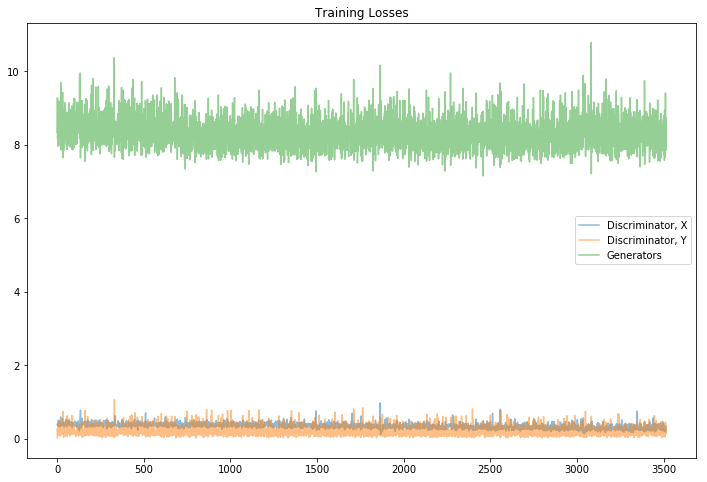

In [75]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# Test Model on Random Input

Input - Output


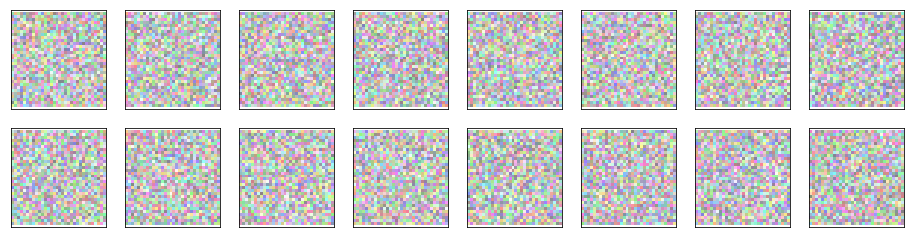

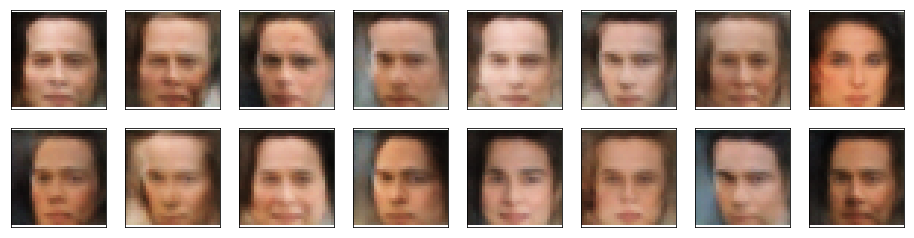

In [216]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))   

# randomly generated, new latent vectors
G_YtoX.eval() # eval mode

print("Input - Output")
# get random
images_Y = get_fake_image()
if train_on_gpu:
    images_Y = images_Y.cuda()
    
# Generate image from random
images_X = G_YtoX(images_Y)

_ = view_samples(0, [images_Y])
_ = view_samples(0, [images_X])

Input - Output


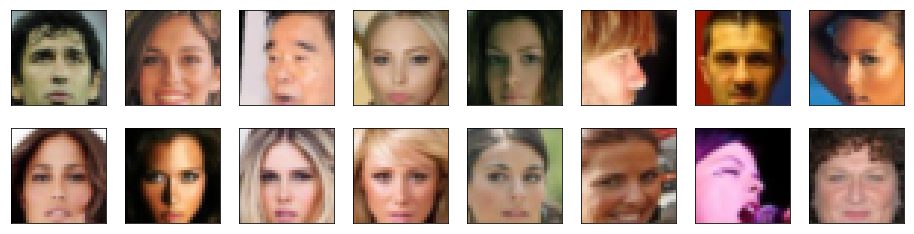

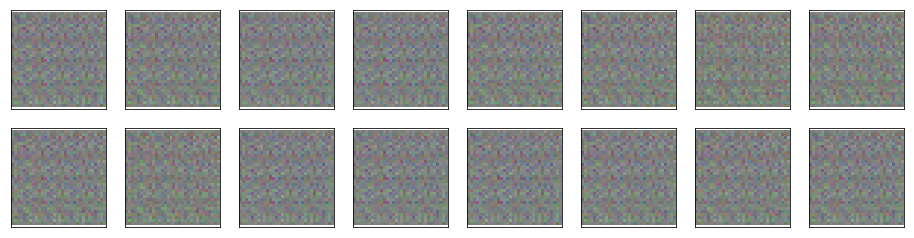

In [205]:
# helper display function
def imshow(img):
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(16, 4))
    plot_size=16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
        img1 = img[idx]
       
        npimg = img1.detach().cpu().numpy()
        npimg = img1.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
 
        
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

imshow(images)
    
G_XtoY.eval() # eval mode
# generated samples
print("Input - Output")
images_X = images
if train_on_gpu:
    images_X = images_X.cuda()

# Generate image from random
images_Y = G_XtoY(images_X)
    
view_samples(0,[images_Y])